In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadVel"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_azmith_resp import RangeAzimuthProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.plotting.movies_mmWave_data import MovieGeneratorMmWaveData


/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadVel.cfg")
# cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR_2_sr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)
print(cfg_manager.vel_res_m_s)
print(cfg_manager.vel_max_m_s)

0.06361778669043376
1.9085336007130127


In [3]:
#load the dataset
dataset_name = "NORTH_RadVel_Test_1"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

/data/RadVel/NORTH_RadVel_Test_1
found 580 radar samples
found 580 lidar samples
found 580 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 580 vehicle velocity samples
found 580 vehicle odometry samples


In [4]:
#load the plotter
plotter = PlotterMmWaveData(config_manager=cfg_manager)

#initialize a range azimuth processor
range_az_processor = RangeAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

#initialize the range doppler processor
range_doppler_processor = RangeDopplerProcessor(
    config_manager=cfg_manager
)

doppler_azimuth_processor = DopplerAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)

#initialize the movie generator
movie_generator = MovieGeneratorMmWaveData(
    cpsl_dataset=dataset,
    plotter=plotter,
    range_azimuth_processor=range_az_processor,
    range_doppler_processor=range_doppler_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path=os.path.join(os.getenv("MOVIE_TEMP_DIRECTORY"),dataset_name)
)

found temp dir: /home/david/Downloads/radnav_temp_dir/movies/NORTH_RadVel_Test_1
clearing temp directory /home/david/Downloads/radnav_temp_dir/movies/NORTH_RadVel_Test_1


(30, 64)


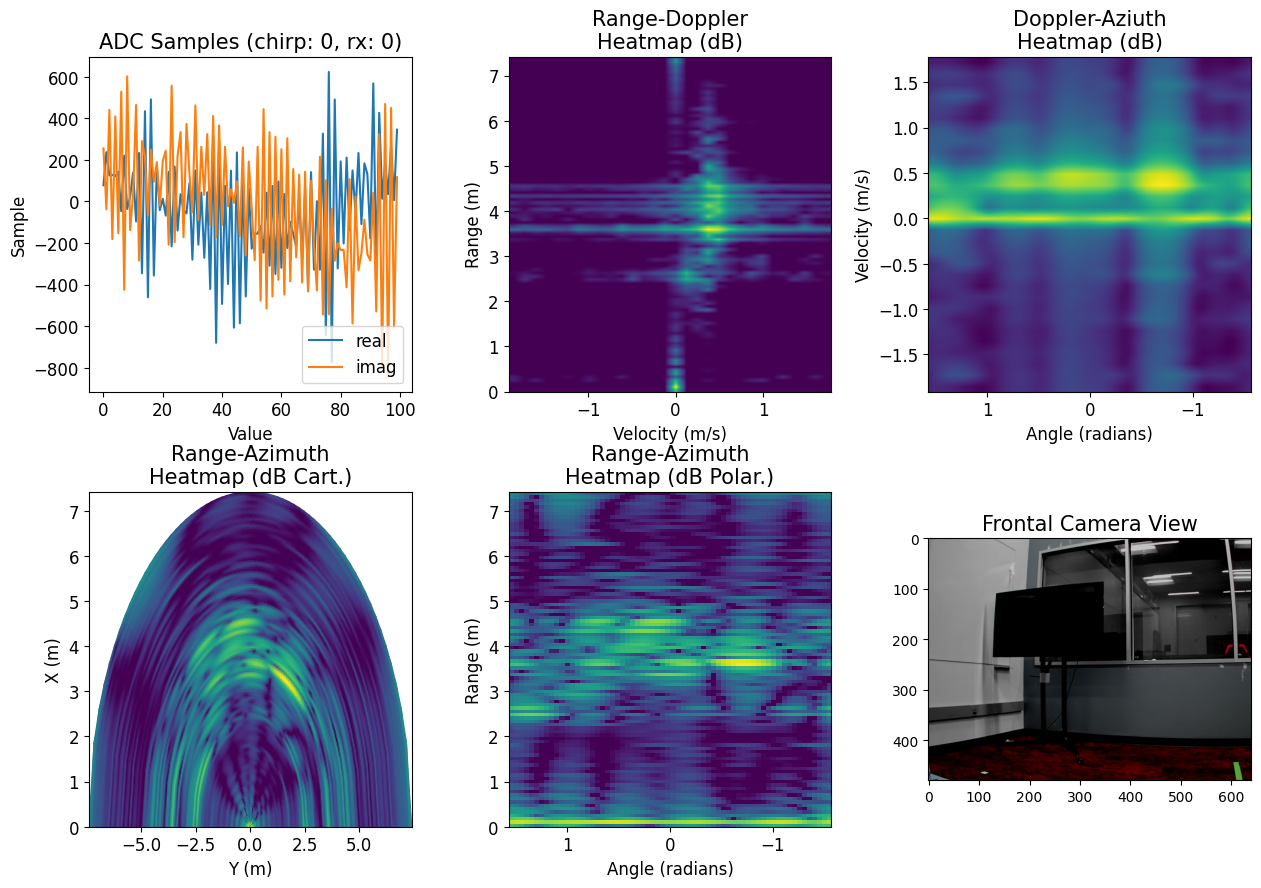

In [5]:
#for getting access to the adc cube
idx=250
adc_cube = dataset.get_radar_data(idx)

adc_cube = virtual_array_reformatter.process(adc_cube)

#for computing the raw responses
rng_az_resp = range_az_processor.process(adc_cube=adc_cube,chirp_idx=0)
rng_dop_resp = range_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)
dop_az_resp = doppler_azimuth_processor.process(adc_cube=adc_cube)

print(dop_az_resp.shape)
try:
    camera_view = dataset.get_camera_frame(idx)
except AssertionError:
    camera_view = np.empty(shape=(0))

#for generating a compilation of plots
fig,axs=plt.subplots(2,3, figsize=(15,10))
fig.subplots_adjust(wspace=0.3,hspace=0.30)

plotter.plot_compilation(
    adc_cube=adc_cube,
    range_doppler_processor=range_doppler_processor,
    range_azimuth_processor=range_az_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    camera_view=camera_view,
    convert_to_dB=True,
    cmap="viridis",
    chirp_idx=0,
    rx_antenna_idx=0,
    axs=axs,
    show=True
)

  0%|          | 0/580 [00:00<?, ?it/s]

100%|██████████| 580/580 [00:41<00:00, 14.12it/s]


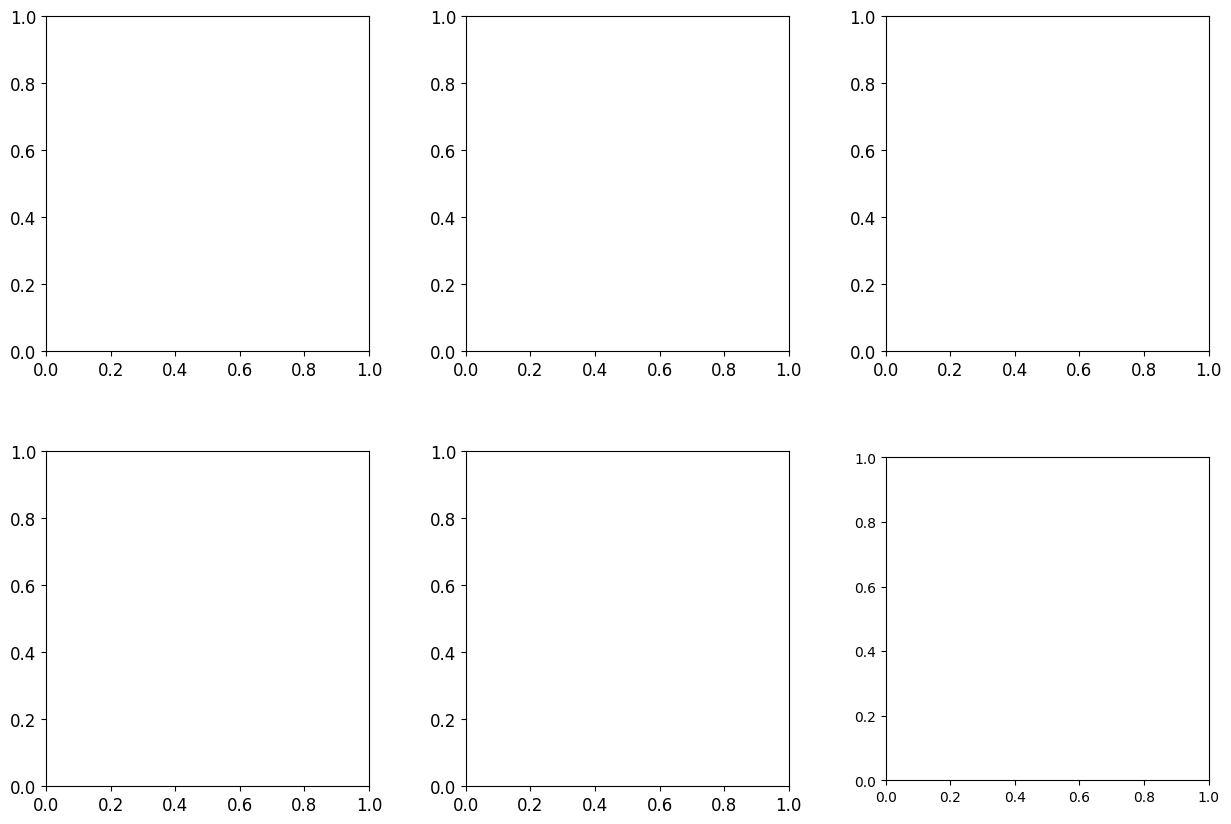

In [6]:
#generate the movie - initialize the figure
movie_generator.initialize_figure(nrows=2,ncols=3,figsize=(15,10))

#generate the movie frames
movie_generator.generate_movie_frames(
    chirp_idx=0,
    rx_antenna_idx=0,
    cmap="viridis",
    convert_to_dB=True
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_UAV.mp4".format(dataset_name),fps=fps)